In [28]:
import sqlite3
import pandas as pd
import filler
import trainer
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Check data quality

In [29]:
def identify_data_issues(df):
    """
    Identify duplicated timestamps, missing intervals, and 
    out-of-order rows in a time-indexed DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing a 'Time' column.
        
    Returns:
        duplicates (pd.DataFrame): Rows that contain duplicate timestamps.
        missing_intervals (pd.DatetimeIndex): Start points of intervals where data is missing.
        is_unordered (bool): True if the data is not strictly time-ordered.
    """
    # Ensure 'Time' is a datetime column
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    
    # Check for any NaT (Not a Time) conversions which indicate invalid timestamps
    if df['Time'].isnull().any():
        raise ValueError("Some timestamps could not be converted to datetime.")
    
    # Check if the data is ordered by 'Time'. If not, sort it.
    if not df['Time'].is_monotonic_increasing:
        is_unordered = True
        df = df.sort_values('Time').reset_index(drop=True)
    else:
        is_unordered = False
    
    # Identify duplicates
    duplicates = df[df.duplicated(subset='Time', keep=False)]

    # Identify missing intervals
    # Calculate the difference between consecutive rows
    time_diffs = df['Time'].diff().dropna()
    # Any gap larger than 1 minute indicates missing intervals
    missing_intervals = time_diffs[time_diffs > pd.Timedelta('1min')]

    return duplicates, missing_intervals, is_unordered

# Example usage:
df = filler.read_data_from_table("ethusd")  # Assuming you have a function that reads from SQLite
duplicates, missing_intervals, is_unordered = identify_data_issues(df)
print("Duplicates:\n", duplicates)
print("Missing intervals:\n", missing_intervals)
print("Data is unordered:", is_unordered)


Duplicates:
 Empty DataFrame
Columns: [Time, Open, High, Low, Close, Volume]
Index: []
Missing intervals:
 Series([], Name: Time, dtype: timedelta64[ns])
Data is unordered: False


# See database

In [30]:
# Define database connection function
def connect_to_sqlite():
    conn = sqlite3.connect("crypto_data.sqlite", check_same_thread=False)
    conn.execute("PRAGMA journal_mode=WAL;")  # Enable concurrent reads and writes
    return conn

def load_preds():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM predictions 
        WHERE timestamp > '2025-01-08 14:30:00'
        ORDER BY timestamp DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('timestamp')

preds = load_preds()
# Remove duplicate rows from the DataFrame
preds = preds.drop_duplicates()
preds

,timestamp,current_close_price,predicted_next_absolute_max,predicted_percentage_change
2935,2025-01-08 14:31:00,3349.11,3347.013672,-0.062594
2934,2025-01-08 14:32:00,3357.73,3343.228760,-0.431876
2933,2025-01-08 14:33:00,3365.32,3349.656494,-0.465439
2932,2025-01-08 14:34:00,3371.75,3358.944580,-0.379786
2931,2025-01-08 14:35:00,3378.22,3361.098877,-0.506809
...,...,...,...,...
4,2025-01-10 18:34:00,3296.53,3287.183594,-0.283523
3,2025-01-10 18:35:00,3295.19,3296.075928,0.026885
2,2025-01-10 18:36:00,3290.58,3286.042969,-0.137879
1,2025-01-10 18:37:00,3290.15,3295.187988,0.153123


In [31]:

def load_data():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM ethusd 
        WHERE Time > '2025-01-08 13:30:00'
        ORDER BY Time DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('Time')

data = load_data()
# Remove duplicate rows from the DataFrame
data = data.drop_duplicates()

data

,Time,Open,High,Low,Close,Volume
3188,2025-01-08 13:31:00,3360.00,3360.00,3357.11,3357.11,120.5655
3187,2025-01-08 13:32:00,3357.62,3359.00,3355.38,3356.34,158.7724
3186,2025-01-08 13:33:00,3356.34,3356.34,3352.49,3355.95,120.1710
3185,2025-01-08 13:34:00,3355.95,3355.95,3352.49,3353.35,125.2615
3184,2025-01-08 13:35:00,3353.98,3360.52,3353.98,3359.07,97.1543
...,...,...,...,...,...,...
4,2025-01-10 18:35:00,3293.84,3295.19,3292.62,3295.19,40.6106
3,2025-01-10 18:36:00,3295.22,3295.22,3290.57,3290.58,34.8341
2,2025-01-10 18:37:00,3290.50,3290.53,3287.24,3290.15,35.8563
1,2025-01-10 18:38:00,3289.10,3289.10,3286.00,3286.35,45.4429


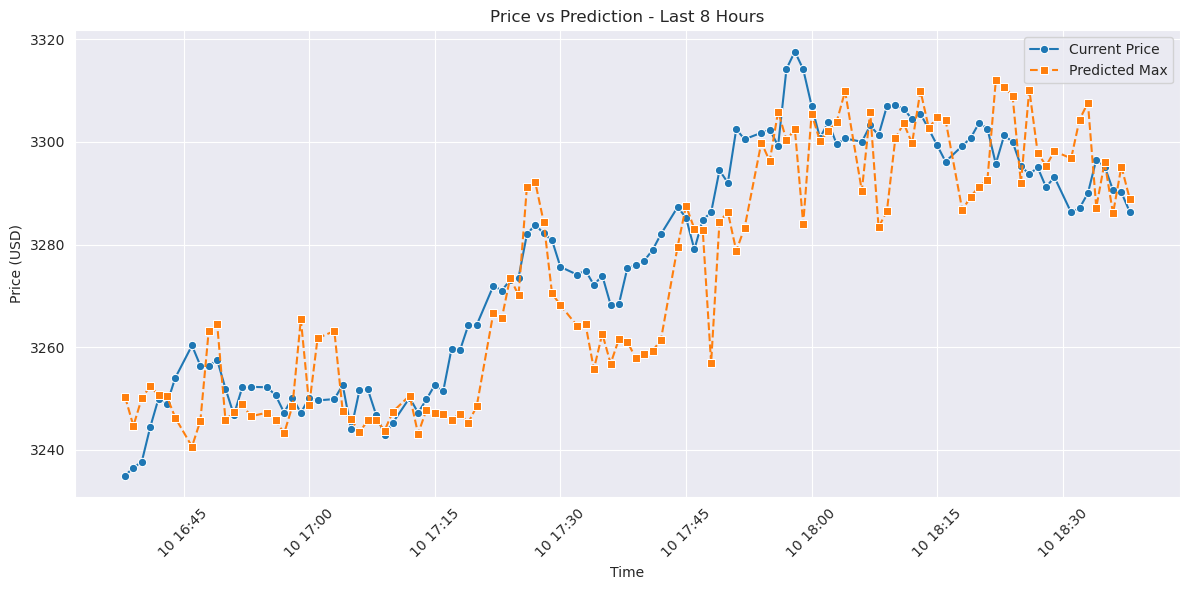

In [32]:
# Convert timestamp column
preds['timestamp'] = pd.to_datetime(preds['timestamp'])

# Filter last 3 hours
cutoff_time = preds['timestamp'].max() - timedelta(hours=2)
df_filtered = preds[preds['timestamp'] >= cutoff_time]

# Create plot
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# Plot lines
sns.lineplot(data=df_filtered, 
            x='timestamp',
            y='current_close_price',
            label='Current Price',
            marker='o')

sns.lineplot(data=df_filtered,
            x='timestamp',
            y='predicted_next_absolute_max',
            label='Predicted Max',
            marker='s',
            linestyle='--')

# Customize plot
plt.title('Price vs Prediction - Last 8 Hours')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Convert to datetime if not already
preds['timestamp'] = pd.to_datetime(preds['timestamp'])
data['Time'] = pd.to_datetime(data['Time'])

# Create a new column in preds for the join key: timestamp minus 60 minutes
preds['timestamp_minus_60'] = preds['timestamp'] - pd.Timedelta(minutes=60)

# Perform a left merge, matching preds.timestamp_minus_60 to data.Time
merged_df = preds.merge(
    data[['Time', 'Close']],            # Select only the columns we need from data
    how='left',
    left_on='timestamp_minus_60',
    right_on='Time'
)

# The merged_df now contains all rows from preds along with the matching 'Close' from data 
# where data.Time = preds.timestamp - 60 minutes.

# You can drop the 'Time' column (from data) and the helper column if you like:
merged_df = merged_df.drop(columns=['Time', 'timestamp_minus_60'])
merged_df['Diff_real_pred'] = 1 - merged_df['Close']/ merged_df['predicted_next_absolute_max']
merged_df


,timestamp,current_close_price,predicted_next_absolute_max,predicted_percentage_change,Close,Diff_real_pred
0,2025-01-08 14:31:00,3349.11,3347.013672,-0.062594,3357.11,-0.003017
1,2025-01-08 14:32:00,3357.73,3343.228760,-0.431876,3356.34,-0.003922
2,2025-01-08 14:33:00,3365.32,3349.656494,-0.465439,3355.95,-0.001879
3,2025-01-08 14:34:00,3371.75,3358.944580,-0.379786,3353.35,0.001666
4,2025-01-08 14:35:00,3378.22,3361.098877,-0.506809,3359.07,0.000604
...,...,...,...,...,...,...
2882,2025-01-10 17:45:00,3285.23,3287.552490,0.070695,3260.79,0.008141
2883,2025-01-10 17:46:00,3279.04,3283.052979,0.122383,3260.34,0.006918
2884,2025-01-10 17:47:00,3284.81,3282.734863,-0.063174,3256.40,0.008022
2885,2025-01-10 17:48:00,3286.25,3256.925293,-0.892346,3256.30,0.000192


In [8]:
print(merged_df['Diff_real_pred'].max())
print(merged_df['predicted_percentage_change'].max())

0.034182608838269624
1.3743029834078602


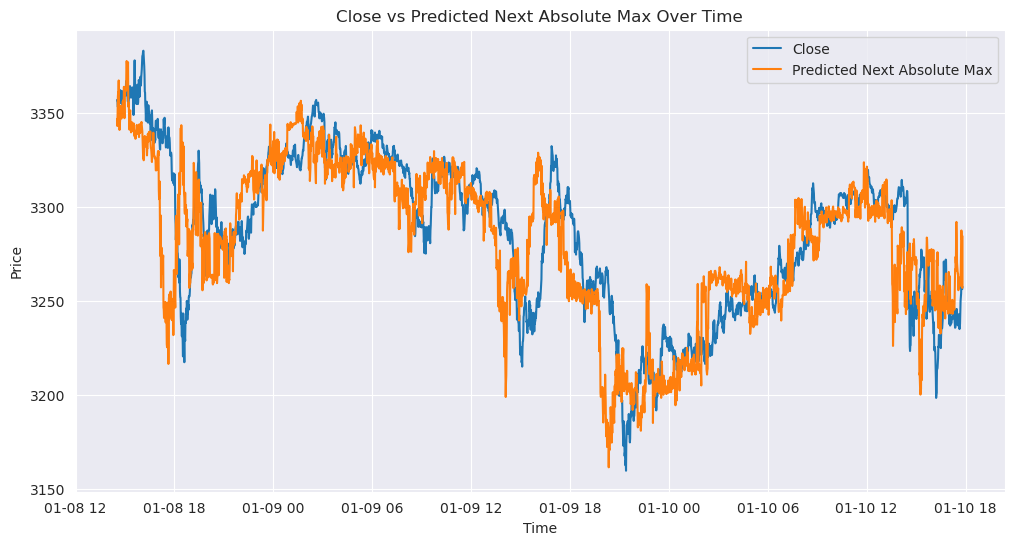

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that timestamp is in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='timestamp', y='Close', label='Close')
sns.lineplot(data=merged_df, x='timestamp', y='predicted_next_absolute_max', label='Predicted Next Absolute Max')

plt.title("Close vs Predicted Next Absolute Max Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


# Run trainer

In [2]:
from trainer import train_model

# Custom hyperparameters
custom_hyperparameters = {
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.1,
    "min_child_weight": 5,
    "colsample_bytree": 0.5,
    "tree_method": 'hist',
}

train_model(hyperparameters=custom_hyperparameters)

Starting model training...
Model training completed and model saved.
